<a href="https://colab.research.google.com/github/meka-williams/Capstone-Finance-AI-Project/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The Lost Boy:
#The Hull moving average and the Directional Moving Index (ADX)

In [1]:
#imports

import requests
from google.colab import userdata
import os, json
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
#API setup

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "GPOTJ4638HWF4A6H")
BASE_URL = "https://www.alphavantage.co/query"

In [3]:
#initial data fetch

def _fetch_json(params, retries=3, sleep_s=15):

    for i in range(retries):
        r = requests.get(BASE_URL, params=params, timeout=30)
        r.raise_for_status()
        payload = r.json()

        #return if valid data was retrieved
        if any("Time Series" in k for k in payload.keys()):
            return payload

        #API limit error
        if "Note" in payload and i < retries - 1:
            print("The API limit has been hit, retrying")
            time.sleep(sleep_s)
            continue

        #payload for debugging
        return payload


In [4]:
#time series fetch - 5 minute interval used to show volatility


def fetch_intraday(symbol: str, interval: str = "5min", outputsize: str = "compact") -> pd.DataFrame:
    """
    Returns DataFrame indexed by datetime with numeric columns.
    """

    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": interval,
        "outputsize": outputsize,
        "apikey": API_KEY,
    }

    #data fetch
    payload = _fetch_json(params)
    key = next((k for k in payload.keys() if "Time Series" in k), None)
    if not key:
        raise ValueError(f"Unexpected API response for {symbol}: {payload}")

    df = pd.DataFrame(payload[key]).T
    df.index = pd.to_datetime(df.index)
    df = df.rename(columns=lambda c: c.split(". ", 1)[-1])  # "1. open" -> "open"
    df = df.apply(pd.to_numeric, errors="coerce").sort_index()

    #save data to CSV
    out_path = DATA_DIR / f"{symbol}_{interval}_intraday.csv"
    df.to_csv(out_path)
    print(f"Downloaded {symbol} ({interval}): {len(df)} rows → {out_path}")
    print(f"Date range: {df.index.min()} → {df.index.max()}")

    return df


Enter a stock symbol (e.g., IBM, AAPL, MSFT): MSFT
Downloaded MSFT (5min): 4224 rows → data/MSFT_5min_intraday.csv
Date range: 2025-09-16 04:00:00 → 2025-10-15 19:55:00

--- Sample of the extracted data ---
                       open    high     low   close  volume
2025-09-16 04:00:00  517.10  517.47  515.70  517.39    4356
2025-09-16 04:05:00  517.33  517.68  516.89  517.29    3009
2025-09-16 04:10:00  517.31  517.80  517.13  517.58    1282
2025-09-16 04:15:00  517.49  517.61  517.25  517.40    1345
2025-09-16 04:20:00  517.40  517.50  516.89  517.09     963

--- Data summary ---
             open         high          low        close        volume
count  4224.00000  4224.000000  4224.000000  4224.000000  4.224000e+03
mean    515.13555   515.730430   514.228100   515.128564  1.203517e+05
std       5.41261     5.929477     6.598928     5.409002  8.034920e+05
min     489.08510   506.290000   475.440100   489.085100  1.400000e+01
25%     510.49000   510.890000   510.083750   510.500000

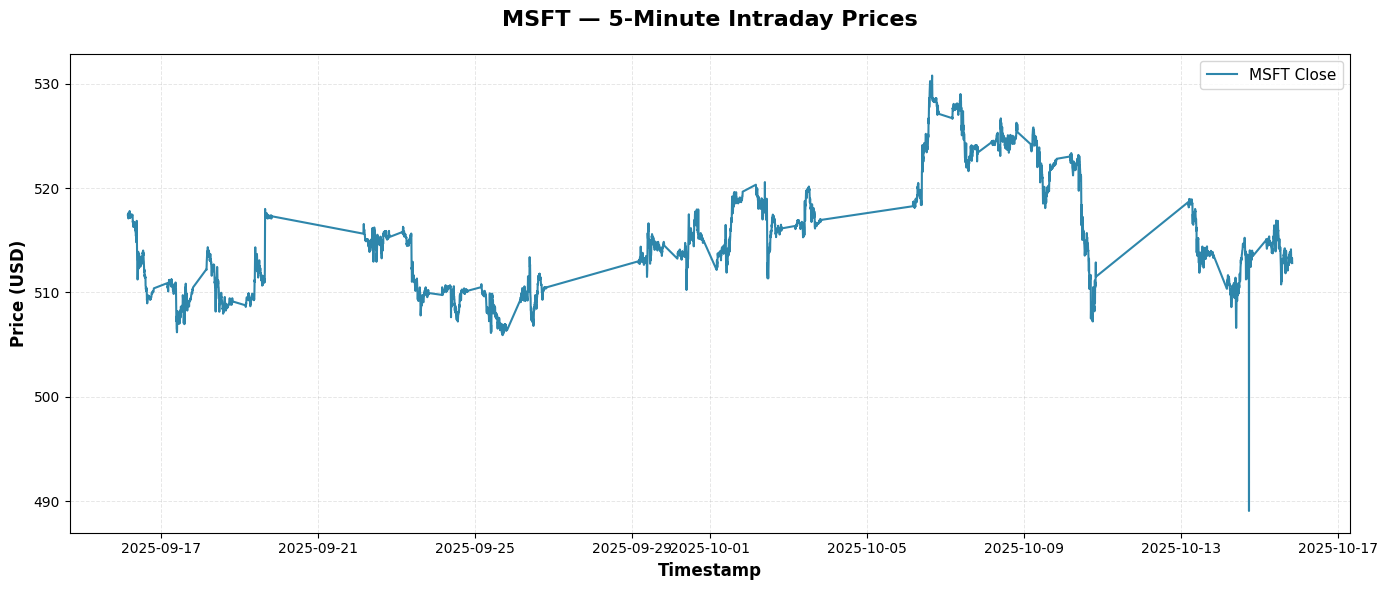

In [6]:
#initial test to validate data extraction

symbol = input("Enter a stock symbol (e.g., IBM, AAPL, MSFT): ").upper()
df = fetch_intraday(symbol, interval="5min", outputsize="full")

#show first 5 rows
print("\n--- Sample of the extracted data ---")
print(df.head())
print("\n--- Data summary ---")
print(df.describe())


#vis
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label=f"{symbol} Close", color="#2E86AB", linewidth=1.5)
plt.title(f"{symbol} — 5-Minute Intraday Prices", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


=== Summary statistics ===
           open      high       low     close        volume
count  4224.000  4224.000  4224.000  4224.000  4.224000e+03
mean    515.136   515.730   514.228   515.129  1.203517e+05
std       5.413     5.929     6.599     5.409  8.034920e+05
min     489.085   506.290   475.440   489.085  1.400000e+01
25%     510.490   510.890   510.084   510.500  8.657500e+02
50%     514.287   514.683   513.802   514.285  4.387000e+03
75%     518.213   518.770   517.512   518.250  1.067198e+05
max     530.880   556.781   530.050   530.771  3.669644e+07


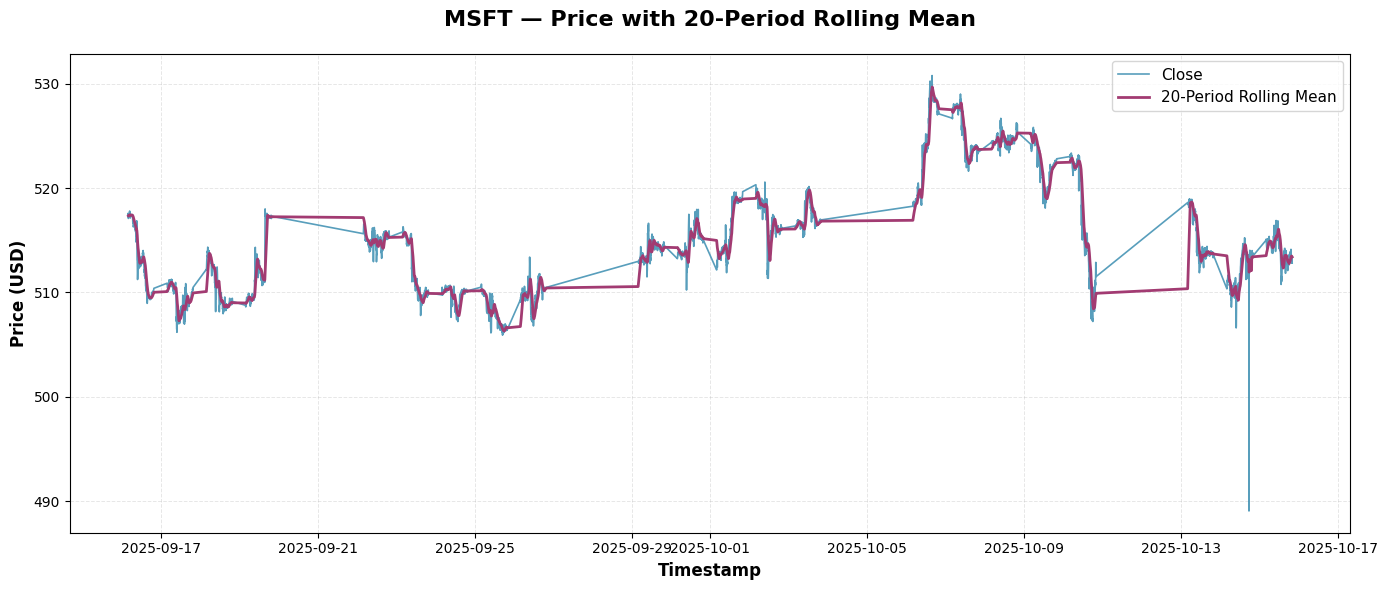

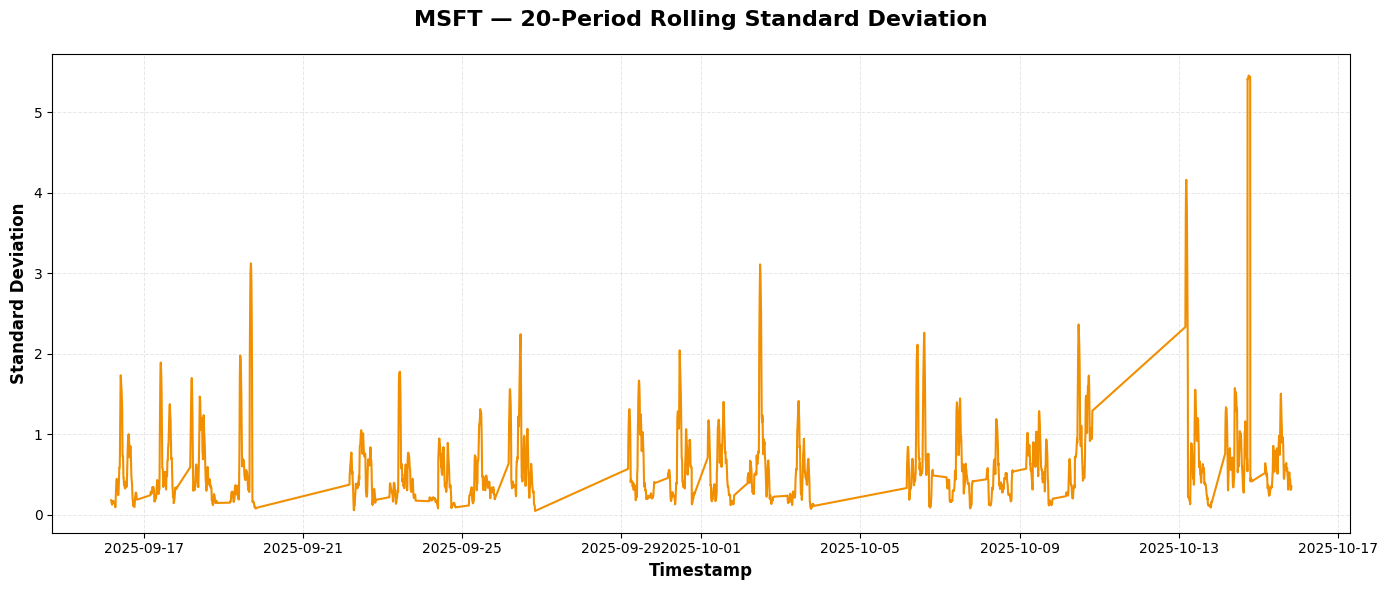

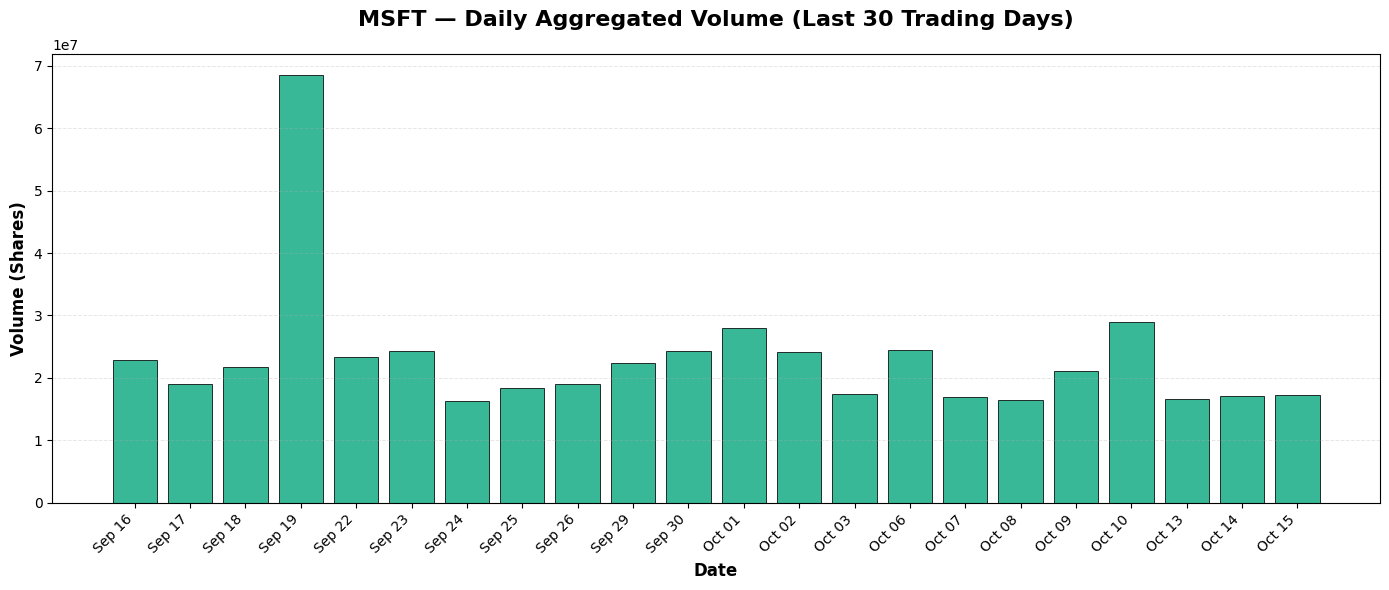

In [16]:
#exploratory visuals (line plot, rolling stats) + summary stats

price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"

#rolling stats
rolling_window = 20
df["roll_mean_20"] = df[price_col].rolling(rolling_window, min_periods=5).mean()
df["roll_std_20"] = df[price_col].rolling(rolling_window, min_periods=5).std()

#daily returns
df["return_1d"] = df[price_col].pct_change()

#summary stats
summary = df[["open","high","low",price_col,"volume"]].describe().round(3)
print("=== Summary statistics ===")
print(summary)

#save summary csv
DATA_DIR = Path("data")
summary.to_csv(DATA_DIR / f"{symbol}_summary_stats.csv")

#price with rolling mean
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], label=price_col.replace('_', ' ').title(),
         color="#2E86AB", linewidth=1.2, alpha=0.8)
plt.plot(df.index, df["roll_mean_20"], label=f"{rolling_window}-Period Rolling Mean",
         color="#A23B72", linewidth=2)
plt.title(f"{symbol} — Price with {rolling_window}-Period Rolling Mean",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

#rolling volatility proxy (std dev)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["roll_std_20"], color="#F18F01", linewidth=1.5)
plt.title(f"{symbol} — {rolling_window}-Period Rolling Standard Deviation",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Standard Deviation", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

#volume by day
df["date"] = df.index.date
daily_volume = df.groupby("date")["volume"].sum()

#last 30 trading days
daily_volume_last = daily_volume[-30:]
plt.figure(figsize=(14, 6))
positions = range(len(daily_volume_last))
plt.bar(positions, daily_volume_last.values, color="#06A77D", alpha=0.8, edgecolor='black', linewidth=0.7)
plt.xticks(positions, [d.strftime("%b %d") for d in daily_volume_last.index], rotation=45, ha='right')
plt.title(f"{symbol} — Daily Aggregated Volume (Last 30 Trading Days)",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Date", fontsize=12, fontweight='bold')
plt.ylabel("Volume (Shares)", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
plt.tight_layout()
plt.show()

=== TIME SERIES CHARACTERISTICS REPORT ===



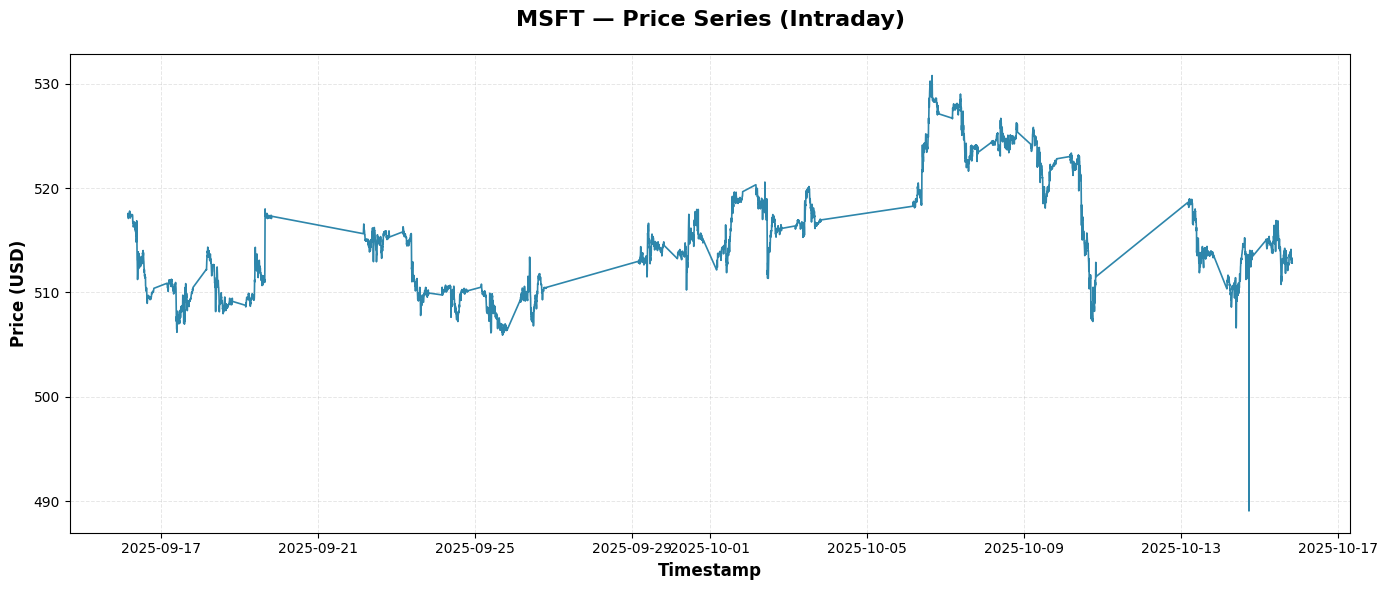

The raw price series shows an upward/downward drift and volatility clustering, suggesting it is likely non-stationary.


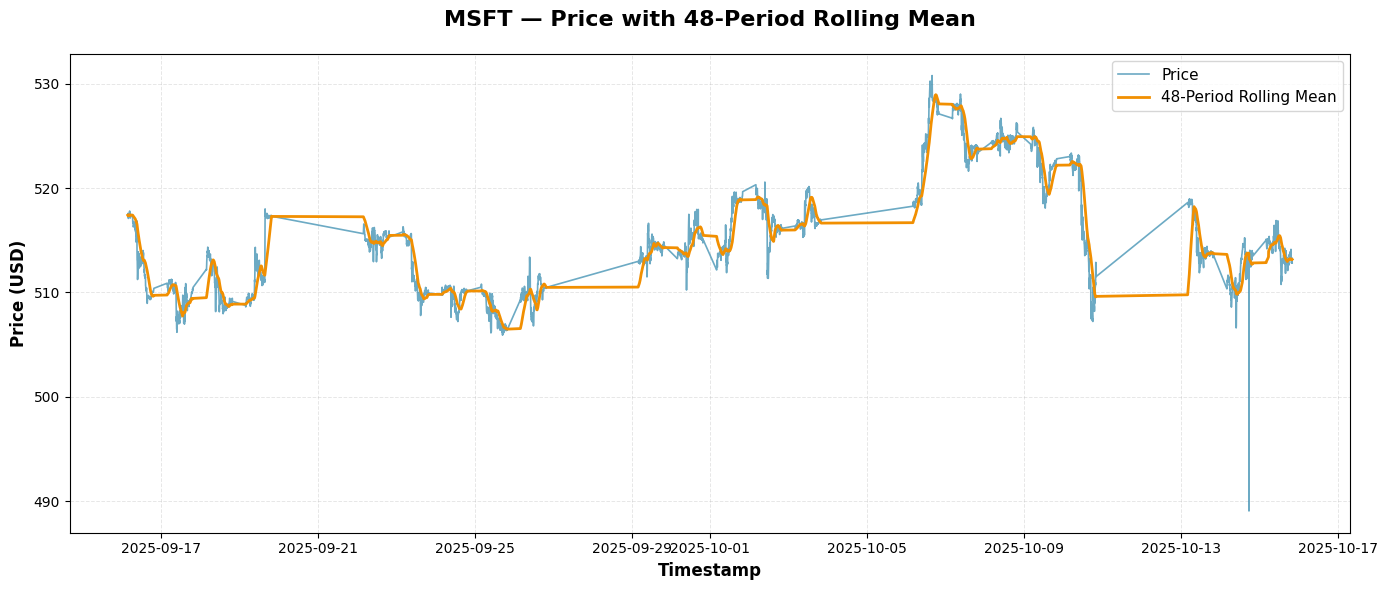

Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.


In [17]:
#prep & clean df for analysis

df = df.sort_index()

#dynamic column names
price_col = next((c for c in df.columns if "close" in c.lower()), "close")
returns_col = "return_1d"
if returns_col not in df:
    df[returns_col] = df[price_col].pct_change()

#frequency
inferred_freq = pd.infer_freq(df.index[:10])
period = 30 if inferred_freq and "D" in inferred_freq else 48
print("=== TIME SERIES CHARACTERISTICS REPORT ===\n")

#plot the raw series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], color="#2E86AB", linewidth=1.2)
plt.title(f"{symbol} — Price Series ({'Daily' if 'D' in str(inferred_freq) else 'Intraday'})",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()
print("The raw price series shows an upward/downward drift and volatility clustering, "
      "suggesting it is likely non-stationary.")

#plot rolling stats
df["roll_mean"] = df[price_col].rolling(window=period, min_periods=1).mean()
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], label="Price", alpha=0.7, color="#2E86AB", linewidth=1.2)
plt.plot(df.index, df["roll_mean"], label=f"{period}-Period Rolling Mean",
         color="#F18F01", linewidth=2)
plt.title(f"{symbol} — Price with {period}-Period Rolling Mean",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()
print("Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.")


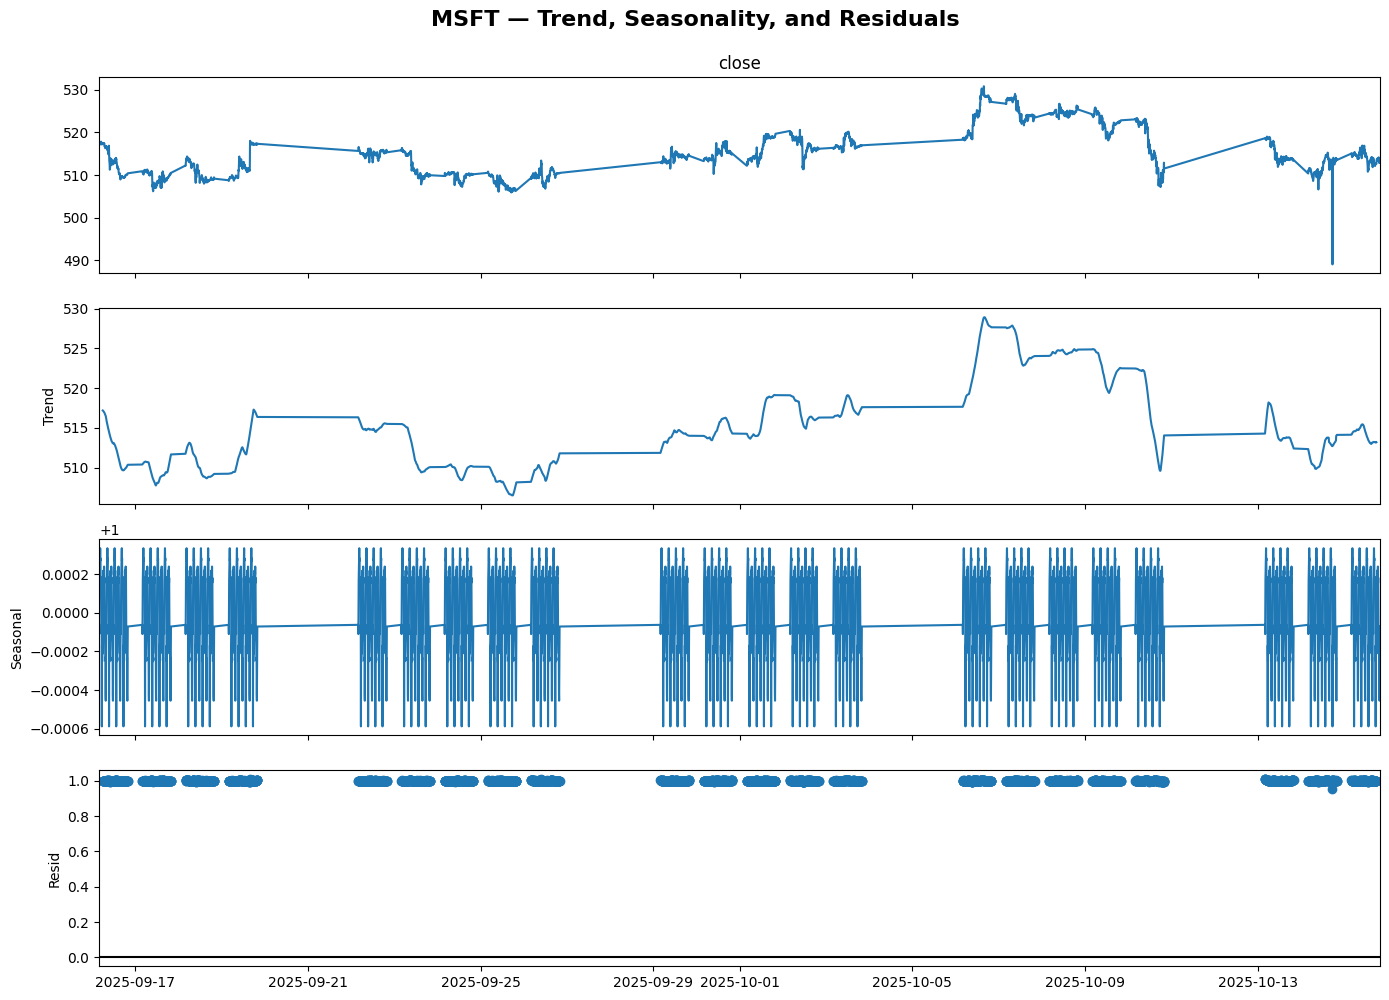

Decomposition separates the series into:
- Trend: Long-term direction of the stock price.
- Seasonality: Repeating short-term cycles (monthly/weekly effects).
- Residuals: Irregular noise not explained by trend or seasonality.



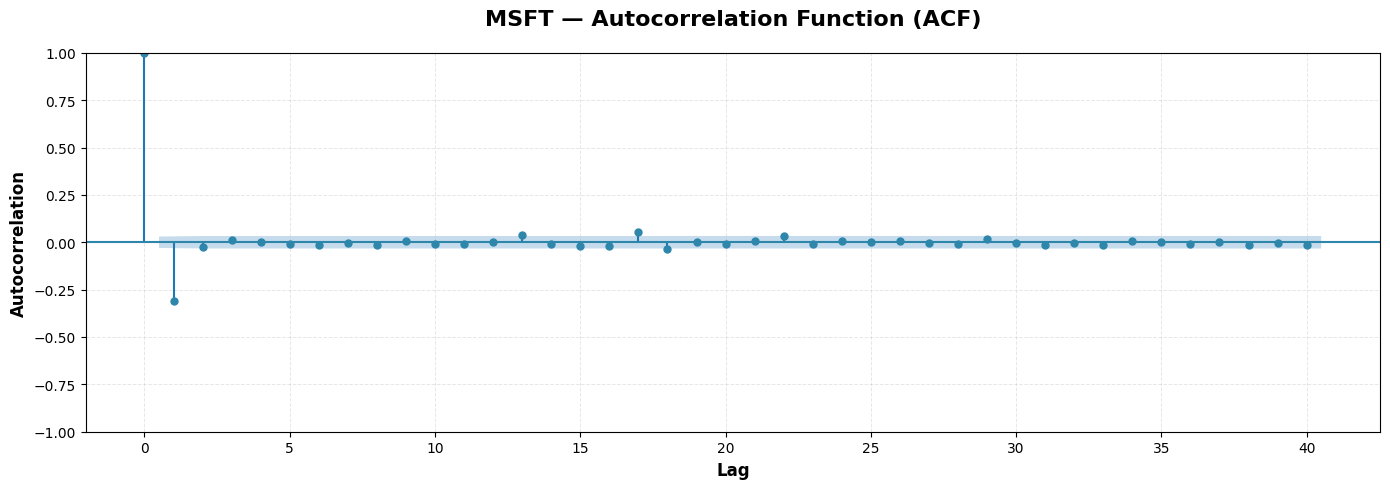

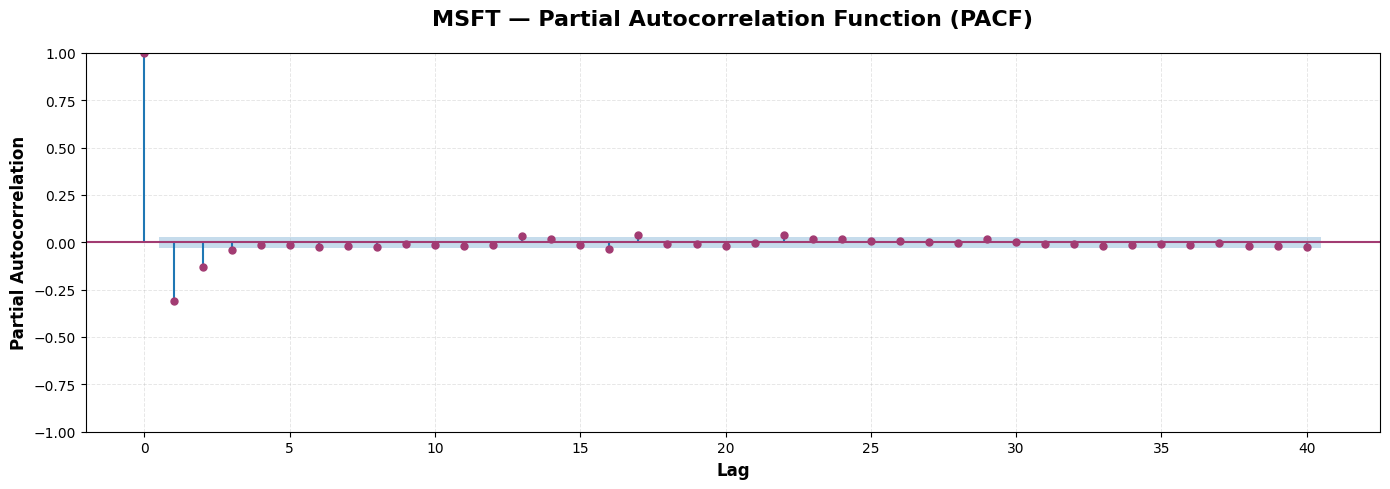

ACF shows correlations with past lags; PACF isolates direct effects of lags. These help identify ARIMA model orders.

=== Augmented Dickey-Fuller Test ===
ADF Statistic: -16.7066
p-value : 0.0000
Critical Values: {'1%': np.float64(-3.4319057050536026), '5%': np.float64(-2.862227424850339), '10%': np.float64(-2.5671359219817984)}
✓ The series is stationary. The null hypothesis is rejected.


In [15]:
#decomposition - trend/seasonality/residuals
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[price_col].dropna(), model="multiplicative", period=period)
fig = result.plot()
fig.set_size_inches(14, 10)
plt.suptitle(f"{symbol} — Trend, Seasonality, and Residuals", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("Decomposition separates the series into:\n"
      "- Trend: Long-term direction of the stock price.\n"
      "- Seasonality: Repeating short-term cycles (monthly/weekly effects).\n"
      "- Residuals: Irregular noise not explained by trend or seasonality.\n")

#ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(14, 5))
plot_acf(df['return_1d'].dropna(), lags=40, ax=ax, color="#2E86AB")
plt.title(f"{symbol} — Autocorrelation Function (ACF)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Lag", fontsize=12, fontweight='bold')
plt.ylabel("Autocorrelation", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 5))
plot_pacf(df[returns_col].dropna(), lags=40, method="ywm", ax=ax, color="#A23B72")
plt.title(f"{symbol} — Partial Autocorrelation Function (PACF)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Lag", fontsize=12, fontweight='bold')
plt.ylabel("Partial Autocorrelation", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()
print("ACF shows correlations with past lags; PACF isolates direct effects of lags. "
      "These help identify ARIMA model orders.")

#ADF Test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df[returns_col].dropna(), autolag='AIC')
print("\n=== Augmented Dickey-Fuller Test ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("✓ The series is stationary. The null hypothesis is rejected.")
else:
    print("✗ The series is non-stationary. Fail to reject null hypothesis. Differencing needed.")

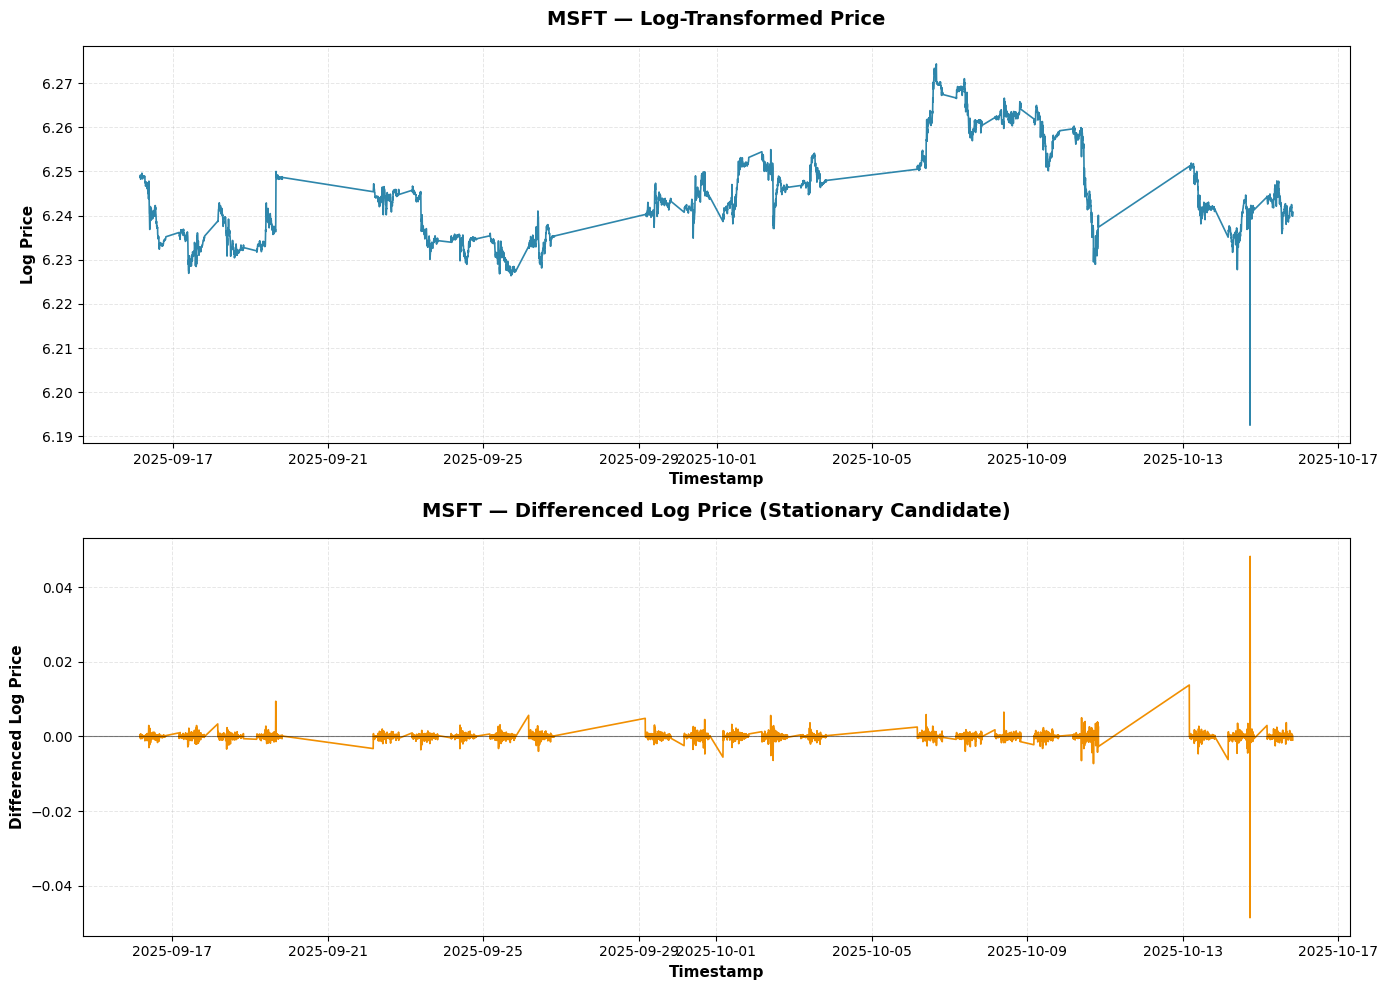


=== ADF on Differenced Log Price ===
ADF Statistic: -16.7258
p-value : 0.0000
Critical Values: {'1%': np.float64(-3.4319057050536026), '5%': np.float64(-2.862227424850339), '10%': np.float64(-2.5671359219817984)}
✓ The differenced series is stationary. Ready for ARIMA modeling.


In [20]:
# Apply Differencing / Transformations

# Log-transform (helps stabilize variance)
df["log_price"] = np.log(df[price_col])
# First difference of log price (approx daily returns)
df["diff_log_price"] = df["log_price"].diff()
# Drop NaNs
stationary_series = df["diff_log_price"].dropna()

#before vs after differencing
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

#log-transformed price
axes[0].plot(df.index, df["log_price"], color="#2E86AB", linewidth=1.2)
axes[0].set_title(f"{symbol} — Log-Transformed Price", fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel("Timestamp", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Log Price", fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

#differenced log price
axes[1].plot(stationary_series.index, stationary_series, color="#F18F01", linewidth=1.2)
axes[1].set_title(f"{symbol} — Differenced Log Price (Stationary Candidate)", fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel("Timestamp", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Differenced Log Price", fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

#re-run ADF test
adf_result = adfuller(stationary_series, autolag="AIC")
print("\n=== ADF on Differenced Log Price ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("✓ The differenced series is stationary. Ready for ARIMA modeling.")
else:
    print("✗ The series may need additional differencing.")

In [21]:
# AR, MA, ARIMA Models

from statsmodels.tsa.arima.model import ARIMA

results = {}

# AR(1) model
model_ar = ARIMA(stationary_series, order=(1,0,0))
fit_ar = model_ar.fit()
results["AR(1)"] = fit_ar

# MA(1) model
model_ma = ARIMA(stationary_series, order=(0,0,1))
fit_ma = model_ma.fit()
results["MA(1)"] = fit_ma

# ARIMA(1,1,1) model (includes differencing)
model_arima = ARIMA(df[price_col], order=(1,1,1))
fit_arima = model_arima.fit()
results["ARIMA(1,1,1)"] = fit_arima

# Compare summary outputs
for name, model in results.items():
    print(f"\n=== {name} ===")
    print(model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== AR(1) ===
                               SARIMAX Results                                
Dep. Variable:         diff_log_price   No. Observations:                 4223
Model:                 ARIMA(1, 0, 0)   Log Likelihood               22066.262
Date:                Thu, 16 Oct 2025   AIC                         -44126.524
Time:                        23:41:21   BIC                         -44107.479
Sample:                             0   HQIC                        -44119.792
                               - 4223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.156e-06    1.8e-05     -0.120      0.905   -3.75e-05    3.31e-05
ar.L1         -0.3098      0.001   -276.407      0.000      -0.312      -0.308
sigma2      1.694e-06   2.61e-09    6

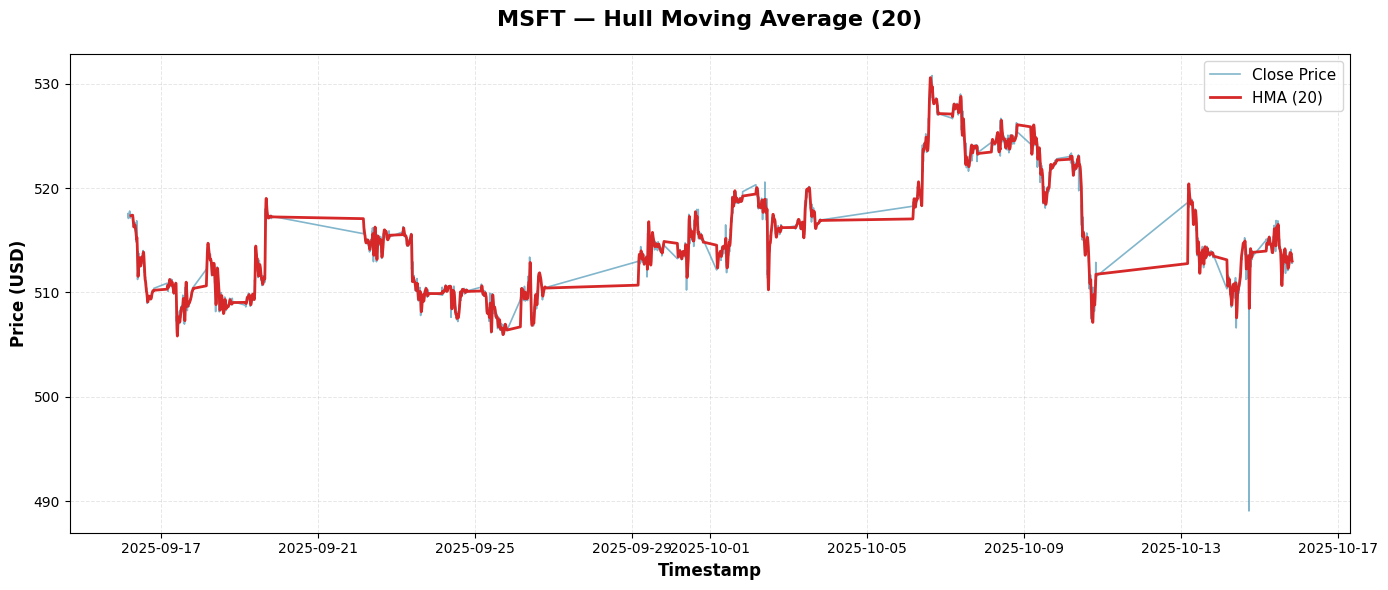

In [23]:
#hull moving average

#weighted moving average - used for hull formula
def WMA(series, period):
    weights = np.arange(1, period + 1)
    return series.rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

#hull moving average
def HMA(series, period=20):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))
    wma_half = WMA(series, half_length)
    wma_full = WMA(series, period)
    diff = 2 * wma_half - wma_full
    return WMA(diff, sqrt_length)

#plot with 20
df["HMA_20"] = HMA(df[price_col], 20)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], label="Close Price", alpha=0.6, color="#2E86AB", linewidth=1.2)
plt.plot(df.index, df["HMA_20"], label="HMA (20)", color="#D62828", linewidth=2)
plt.title(f"{symbol} — Hull Moving Average (20)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


=== Trend Strength Analysis — ADX / DMI ===


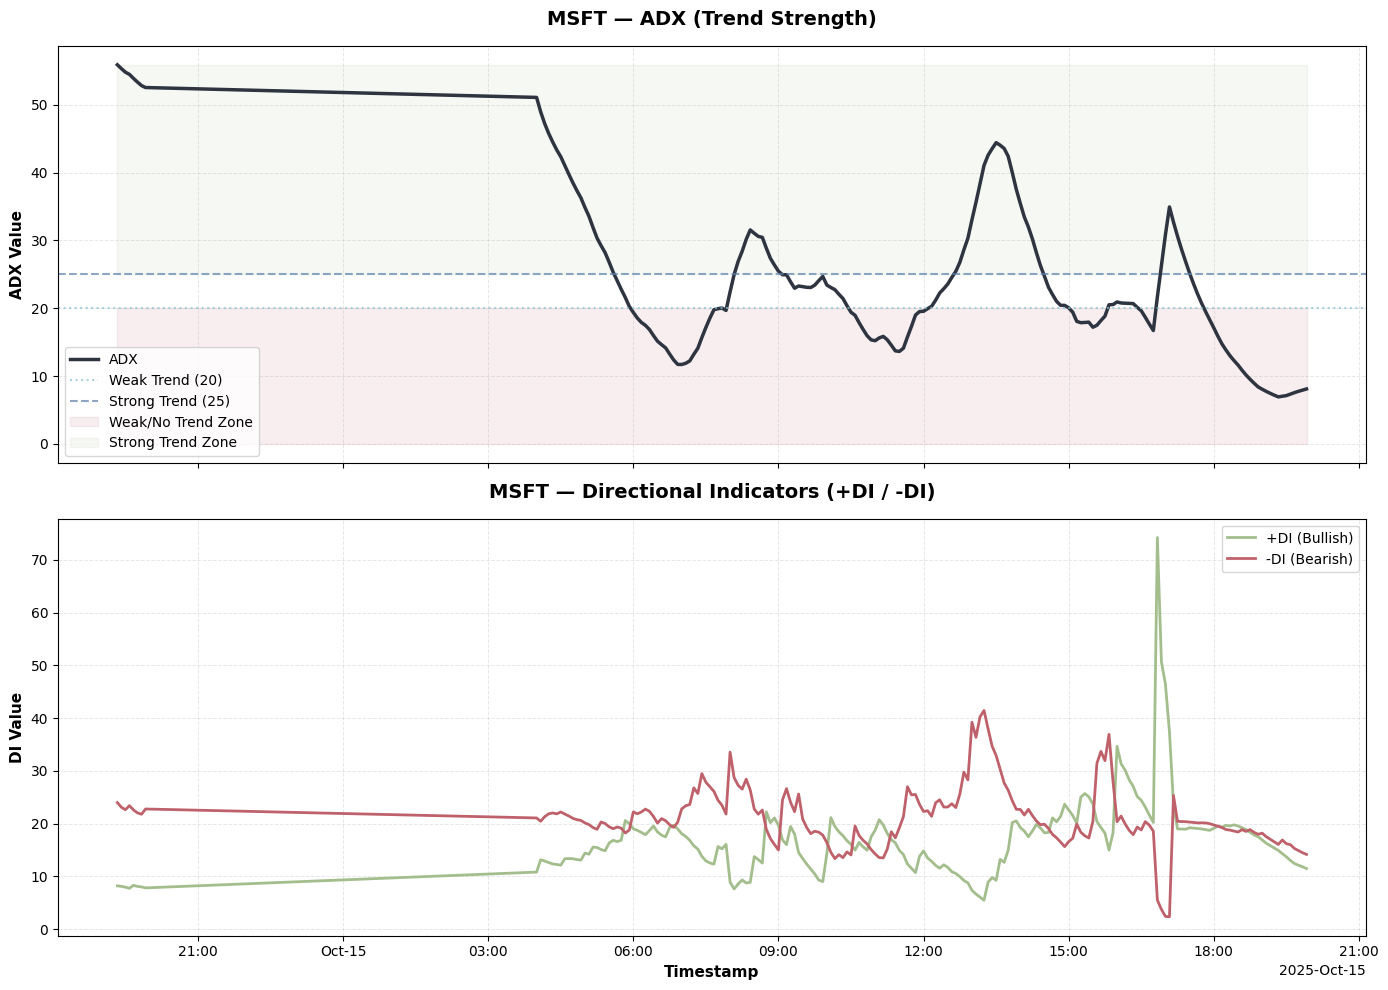


Interpretation:
• ADX > 25 → Strong trend; ADX < 20 → Weak/sideways trend
• +DI > -DI → Bullish trend; -DI > +DI → Bearish trend
• Crossovers of +DI and -DI indicate potential buy/sell signals


In [28]:
#directional moving index (DMI) & ADX visualization
from ta.trend import ADXIndicator
import matplotlib.dates as mdates

print("\n=== Trend Strength Analysis — ADX / DMI ===")
#smaller interval range for graph clarity and readability
window = 14
N = 200

#DMI calculations
adx_indicator = ADXIndicator(
    high=df["high"],
    low=df["low"],
    close=df[price_col],
    window=window
)
df["ADX"] = adx_indicator.adx()
df["DMI_plus"] = adx_indicator.adx_pos()
df["DMI_minus"] = adx_indicator.adx_neg()

#only plot recent data
df_plot = df.iloc[-N:]
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#ADX — trend strength
axes[0].plot(df_plot.index, df_plot["ADX"], color="#2E3440", linewidth=2.5, label="ADX")
axes[0].axhline(20, color="#88C0D0", linestyle=":", linewidth=1.5, label="Weak Trend (20)", alpha=0.7)
axes[0].axhline(25, color="#5E81AC", linestyle="--", linewidth=1.5, label="Strong Trend (25)", alpha=0.7)
axes[0].fill_between(df_plot.index, 0, 20, alpha=0.1, color="#BF616A", label="Weak/No Trend Zone")
axes[0].fill_between(df_plot.index, 25, df_plot["ADX"].max(), alpha=0.1, color="#A3BE8C", label="Strong Trend Zone")
axes[0].set_title(f"{symbol} — ADX (Trend Strength)", fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel("ADX Value", fontsize=11, fontweight='bold')
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[0].xaxis.set_major_locator(locator)
axes[0].xaxis.set_major_formatter(formatter)

#DI+ and DI− — trend direction
axes[1].plot(df_plot.index, df_plot["DMI_plus"], color="#A3BE8C", linewidth=2, label="+DI (Bullish)")
axes[1].plot(df_plot.index, df_plot["DMI_minus"], color="#BF616A", linewidth=2, label="-DI (Bearish)")
axes[1].set_title(f"{symbol} — Directional Indicators (+DI / -DI)", fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel("DI Value", fontsize=11, fontweight='bold')
axes[1].set_xlabel("Timestamp", fontsize=11, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

#results
print("\nInterpretation:")
print("• ADX > 25 → Strong trend; ADX < 20 → Weak/sideways trend")
print("• +DI > -DI → Bullish trend; -DI > +DI → Bearish trend")
print("• Crossovers of +DI and -DI indicate potential buy/sell signals")

In [ ]:
#evaluating model accuracy

from sklearn.metrics import mean_squared_error

eval_rows = []

for name, model in results.items():
    aic = model.aic
    bic = model.bic

    # fitted values as a Pandas Series
    fitted = pd.Series(model.fittedvalues)

    # target (endogenous) series used by THIS model, with same index as fitted
    # (works across AR/MA on stationary_series and ARIMA on levels)
    try:
        endog = pd.Series(model.model.endog, index=fitted.index)
    except Exception:
        # Fallback: reindex your stationary series to fitted's index
        endog = pd.Series(stationary_series).reindex(fitted.index)

    # align & drop NaNs to ensure equal length
    aligned = pd.concat([endog.rename("y_true"), fitted.rename("y_hat")], axis=1).dropna()

    rmse = np.sqrt(mean_squared_error(aligned["y_true"], aligned["y_hat"]))
    n_used = len(aligned)

    eval_rows.append((name, aic, bic, rmse, n_used))

eval_df = pd.DataFrame(eval_rows, columns=["Model", "AIC", "BIC", "RMSE (in-sample)", "N used"])
print("=== Model Comparison (aligned) ===")
eval_df = eval_df.sort_values("AIC").reset_index(drop=True)
print(eval_df)


=== Model Comparison (aligned) ===
          Model           AIC           BIC  RMSE (in-sample)  N used
0         MA(1) -42017.808431 -41998.903122          0.001318    4031
1         AR(1) -42008.501916 -41989.596606          0.001320    4031
2  ARIMA(1,1,1)   2411.150024   2430.055333        250.875198    4031
